In [1]:
from maMDP.agents import Agent
from maMDP.mdp import SquareGridMDP, HexGridMDP, MDP
from maMDP.environments import Environment
from maMDP.algorithms.action_selection import SoftmaxActionSelector
import numpy as np
import matplotlib.pyplot as plt

## Creating an environment

The `Environment` class provides a way for any number of agents to act with a Markov Decision Problem (MDP).

The first thing we need to do is define an agent, using the `Agent` class. When we define the agent, we need to specify its name, which is used to identify it later on.
2. 

Here we create an agent called `testAgent`.

In [2]:
new_agent = Agent('testAgent')

We also need to define the MDP, which is done using the `MDP` class. An MDP here is defined by its transition function, which is implemented as a Numpy array with the shape `n states, n actions, n states` - this represents the result of taking a given action in a given state and can be either deterministic (i.e. taking a given action in a given state leads to a single state with 100% probability) or probabilistic (i.e. taking a given action in a given state can lead to multiple other states with different probabilities). 

The `MDP` object also contains information about the features associated with each state, represented by a Numpy array with the shape `n features, n states`. The values of this array are arbitrary and will depend on the particular features being implemented.

### Standard MDPs

Two MDPs are implemented for ease of use - square and hexagonal grids. These allow a grid of a certain shape to be specified easily, without having to specificy the transition function manually.

Here we'll use a square grid, using the `SquareGridMDP` class. We'll give it a shape of 15 x 15 cells, and place the first feature in one corner of the grid.

In [3]:
grid_shape = (15, 15)

# Create an array representing the two features
features = np.zeros((2, np.product(grid_shape)))

# The first feature is placed in the bottom right corner of the grid. The second feature isn't present.
features[0, 220:] = 1
features[0, 205:210] = 1

new_mdp = HexGridMDP(shape=grid_shape, features=features)

Finally, we wrap our agent and our MDP together using the `Environment` class. 

When creating the object, the first argument we pass is the `MDP` object we just created. The second argument is a dictionary which specifies the agents we want to use and their starting positions. Keys represent `Agent` objects, while values represent three values relating to how the agent interacts with the MDP, supplies as a 3-tuple. These are:
1. The starting position of the agent (representing the state we want to start it in).
2. Its reward function for the MDP it's going to be interacting with. This is specified as a list with an entry corresponding to each feature in the MDP, plus an entry for each agent (including itself). This means that the agent can value not only the static features in the environment, but also the agents in the environment. The higher the number, the greater the value of that feature.
3. Which features it consumes when it encounters them - i.e. if a state contains a feature, does it disappear from that state if the agent enters it.

For this example, we're going to place our single agent (`new_agent`) in the environment, starting it at state #2. Its reward function places a weight of `1` on the first feature in the environment, `0` on the second feature and a value of `0` for the only agent in the environment (itself). It doesn't consume any features, as indicated by an empty list (`[]`).

In [4]:
new_env = Environment(new_mdp, {new_agent: (2, [1, 0, 0], [])})

## Plotting the environment

The `Environment` class implements methods for plotting the environment, which we can use to see what we've created.

> **_Note:_**  When calling the plotting methods of the `Environment` class, this in turn calls methods implemented in the `MDP` class. Plotting will differ depending on the type of MDP, and appropriate methods will need to be implemented for any custom MDPs.

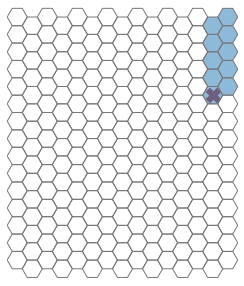

In [5]:
new_env = Environment(new_mdp, {new_agent: (205, [1, 0, 0], [])})
new_env.plot(mdp_plotting_kwargs={'figsize': (5, 5)}, agent_plotting_kwargs={'s': 200}, agent_colours={'testAgent': '#bd4848'})

We can see our agent has appeared in the top left of the grid, while our feature is present in the bottom right corner.

## Interacting with the MDP

Each agent is able to interact with the associated MDP. Generally, we will want to figure out the best action to take in the current state, and then take that action to move the agent to the subsequent state.

First, we need to figure out the best state to move to next. To achieve this, the `Agent` class has a `.fit()` method, which will determine the best action from the current state. This happens in two steps:

### Calculating action values
First, action values are calculated. By default, the agent will use value iteration to solve the MDP and calculate Q values for each action. This can be changed by changing the value passed to the `algorithm` argument when creating the `Agent`.

### Selecting an action
Given the calculated Q values, actions can then be chosen using any decision rule. By default, the agent will use the max rule - that is, taking the action with the highest Q value. This is set by passing a different action selector to the `action_selector` argument when creating the `Agent`. 

To fit the agent, rather than calling the agent's own `.fit()` method, we can use the `.fit()` method of the environment and specify the agent we wish to fit.

In [6]:
new_env.fit('testAgent')

Once we've figured out the best action to take, we can move the agent. This can be done using the `.step()` method of the environment, again specifying the agent we want to move.

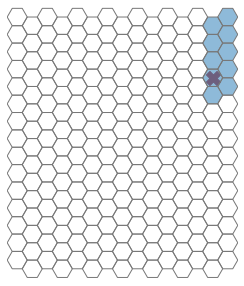

In [7]:
new_env.step('testAgent')
new_env.plot(mdp_plotting_kwargs={'figsize': (15, 5)}, agent_plotting_kwargs={'s': 200}, agent_colours={'testAgent': '#bd4848'})

We can see that the agent has now moved down one cell.

Often we will want to move more than one step at a time. Assuming the MDP has been solved (i.e. we have Q values for every action in every state), we can use the `.step_multi()` method to achieve this by supplying the agent we wish to move and the number of steps we want to take.

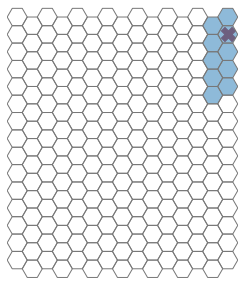

In [8]:
new_env.step_multi('testAgent', 25)
new_env.plot(mdp_plotting_kwargs={'figsize': (15, 5)}, agent_plotting_kwargs={'s': 200}, agent_colours={'testAgent': '#bd4848'})

Our agent has now moved to the bottom right.

## Plotting trajectories

It's often useful to be able to see the states the agent has visited during its travels.

First, we can get the agent's history of states visited using the `.get_agent_position_history()` method. We can plot this using the `.plot_trajectory()` method (assuming the `MDP` being used has methods to plot trajectories implemented).

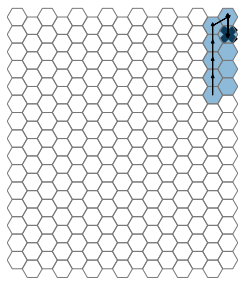

In [9]:
trajectory = new_env.get_agent_position_history('testAgent')

# First plot the environment
ax = new_env.plot(mdp_plotting_kwargs={'figsize': (15, 5)}, agent_plotting_kwargs={'s': 300})

# Add the trajectory
new_env.plot_trajectory(trajectory, ax)

## Plotting state values

Algorithms used to solve the MDP will typically estimate the value function for the MDP, and we can also plot this using the `.plot_state_values()` method.

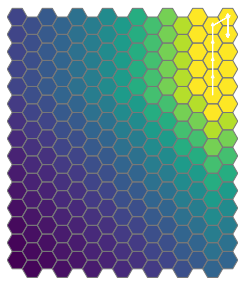

In [10]:
ax = new_env.plot_state_values('testAgent', figsize=(15, 5))
new_env.plot_trajectory(trajectory, ax, colour='white')

## Resetting the environment

To reset the environment back to its starting state, we use the `.reset()` method. 

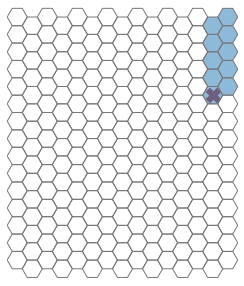

In [11]:
new_env.reset()
new_env.plot(mdp_plotting_kwargs={'figsize': (15, 5)}, agent_plotting_kwargs={'s': 200}, agent_colours={'testAgent': '#bd4848'})

## Consuming features

We can repeat this with an agent that consumes features as it comes across them.

With the following specification, the agent will new consume the first feature.

In [12]:
new_agent = Agent('testAgent')
new_mdp = HexGridMDP(shape=grid_shape, features=features)
new_env_consume = Environment(new_mdp, {new_agent: (2, [1, 0, 0], [0])})

If we solve the MDP and move the agent around, we can see that the feature has disappeared from the states the agent has visited.

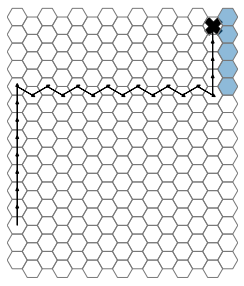

In [13]:
new_env_consume.fit('testAgent')
new_env_consume.step_multi('testAgent', 25)

trajectory = new_env_consume.get_agent_position_history('testAgent')

# First plot the environment
ax = new_env_consume.plot(mdp_plotting_kwargs={'figsize': (15, 5)}, agent_plotting_kwargs={'s': 300})

# Add the trajectory
new_env_consume.plot_trajectory(trajectory, ax)

We can also see how much of each feature the agent has consumed - this is useful for determining how much reward an agent has gained, for example.

In [14]:
new_env_consume.agents['testAgent'].consumed

array([5., 0., 0.])